In [1]:
import scanpy as sc
import pandas as pd

In [71]:
try:
    del fdata, gdata
    del count_matrix
    del new_gdata
except:
    pass

In [6]:
data_dir = "/data200T/SPACseq/HD/output/subq/outs/binned_outputs/square_016um/"

pd.read_parquet(data_dir + 'spatial/tissue_positions.parquet').to_csv(data_dir + 'spatial/tissue_positions_list.csv', index=False)
fdata = sc.read_visium(path=data_dir,
                       count_file='filtered_feature_bc_matrix.h5',
                       library_id='subq',
                       source_image_path='spatial/aligned_tissue_image.png')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/readwrite.py:415: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(files["tissue_positions_file"], header=None)


In [7]:
fdata.obs['in_tissue'] = fdata.obs['in_tissue'].astype(str)
fdata.obs['array_row'] = fdata.obs['array_row'].astype(str)
fdata.obs['array_col'] = fdata.obs['array_col'].astype(str)

fdata.obsm['spatial'] = fdata.obsm['spatial'].astype(float)

fdata.write_h5ad(data_dir + 'combined.h5ad')

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix

gdata = fdata[:, fdata.var_names.str.startswith('sg')].copy()

sgs = gdata.var_names.str.split('_', n=1).str[0]
sgs_unique = sgs.unique()
count_matrix = np.zeros((len(gdata.obs), len(sgs_unique)))

for i, sg in tqdm(enumerate(sgs_unique)):
    sg_data = gdata[:, sgs == sg].X.toarray().sum(axis=1).reshape(-1)
    count_matrix[:, i] = sg_data

new_gdata = ad.AnnData(csr_matrix(count_matrix), obs=gdata.obs, var=pd.DataFrame(index=sgs_unique))
new_gdata.obsm['spatial'] = gdata.obsm['spatial']

736it [00:22, 32.15it/s]


In [9]:
new_gdata.obs['in_tissue'] = new_gdata.obs['in_tissue'].astype(str)
new_gdata.obs['array_row'] = new_gdata.obs['array_row'].astype(str)
new_gdata.obs['array_col'] = new_gdata.obs['array_col'].astype(str)

new_gdata.obsm['spatial'] = new_gdata.obsm['spatial'].astype(float)

new_gdata.write_h5ad(data_dir + 'guide_combined.h5ad')

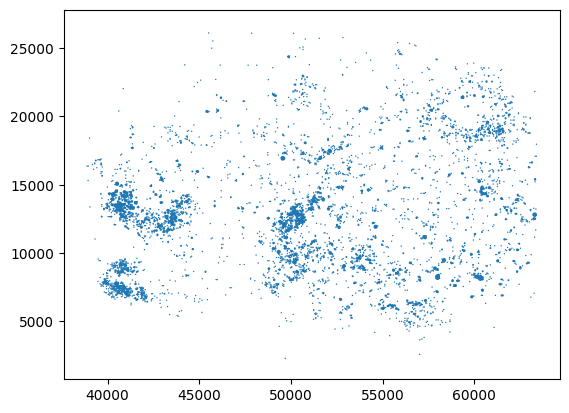

In [10]:
sns.scatterplot(x=new_gdata.obsm['spatial'][:, 0], y=new_gdata.obsm['spatial'][:, 1],
                s=new_gdata[:, 'sgnon-targeting'].X.toarray().flatten())
plt.show()